In [1]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.pyaudio_helper as pah
import scipy.signal as signal
import time
import sys
import imp # for module development and reload()
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# Introduction
A simplified block diagram of PyAudio *streaming-based* (nonblocking) signal processing.

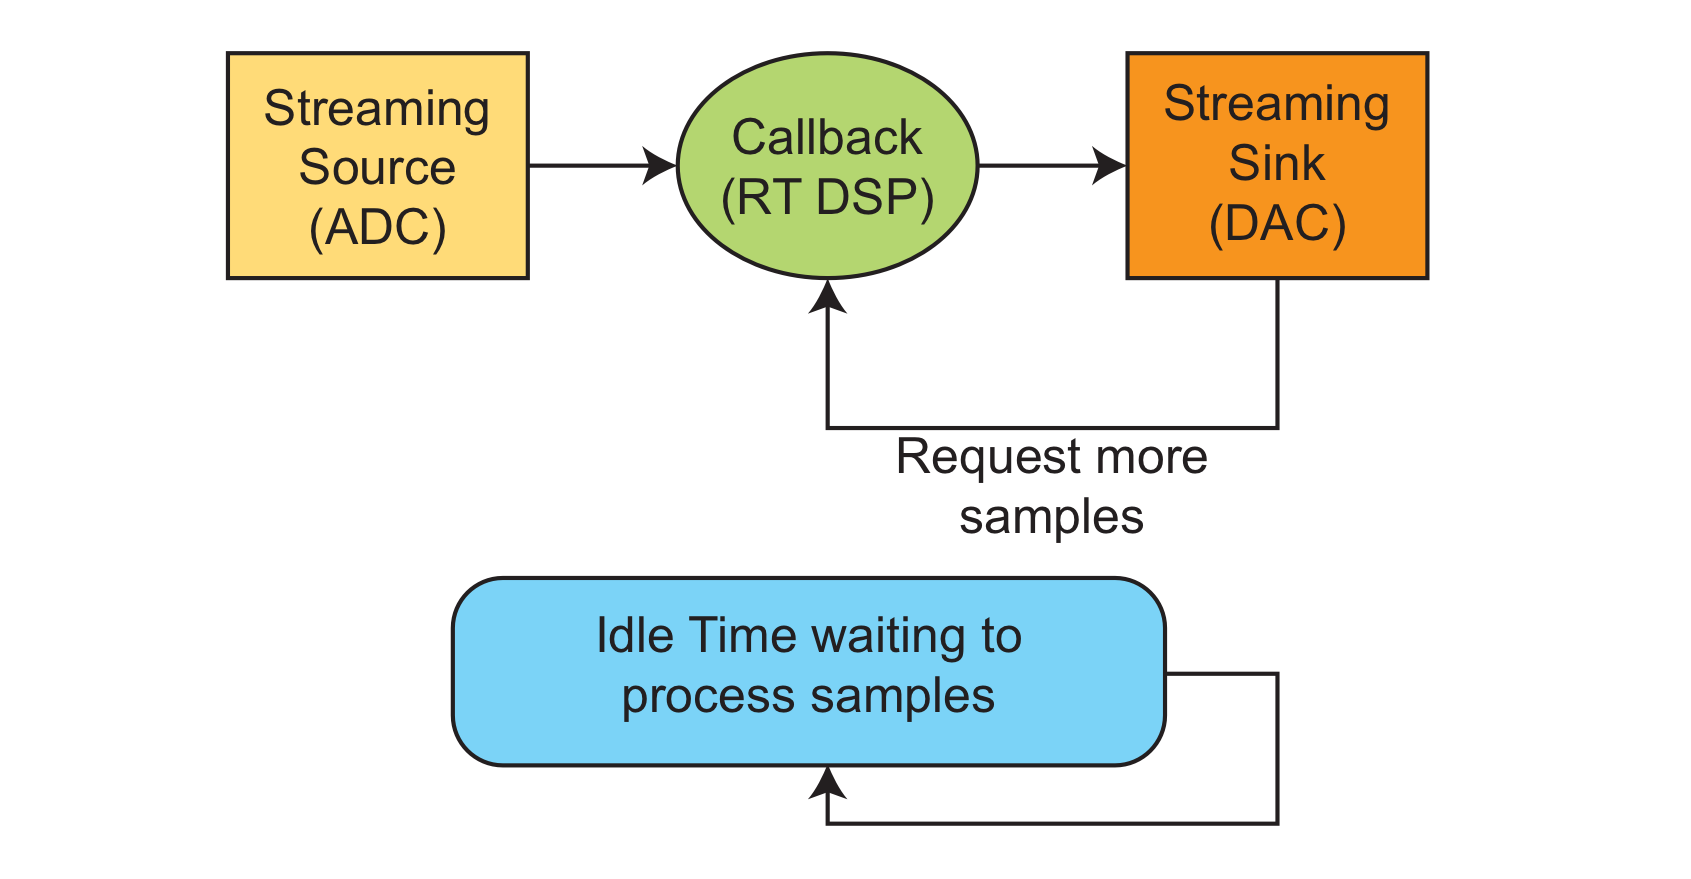

In [3]:
Image('PyAudio_RT_flow@300dpi.png',width='90%')

In [3]:
pah.available_devices()

Index 0 device name = Built-in Microphone, inputs = 2, outputs = 0
Index 1 device name = Built-in Output, inputs = 0, outputs = 2
Index 2 device name = USB Audio Device, inputs = 1, outputs = 2


# Real-Time Loop Through
Here we set up a simple `callback` function that passes the input samples directly to the output. The module `pyaudio_support` provides a class for managing a `pyaudio` stream object, capturing the samples processed by the `callback` function, and collection of performance metrics. Once the `callback` function is written/declared a `DSP_io_stream` object can be created and then the `stream(Tsec)` method can be executed to start the input/output processing, e.g.,

```python
import pyaudio_helper as pah

DSP_IO = pah.DSP_io_stream(callback,in_idx, out_idx)
DSP_IO.stream(2)
```
where `in_idx` is the index of the chosen input device found using `available_devices()` and similarly `in_idx` is the index of the chosen output device.

* The `callback` function must be written first as the function name used by the object to call the *callback*.

In [4]:
# define a pass through, y = x, callback
def callback(in_data, frame_count, time_info, status):
    DSP_IO.DSP_callback_tic()
    # convert byte data to ndarray
    in_data_nda = np.fromstring(in_data, dtype=np.int16)
    #***********************************************
    # DSP operations here
    # Here we apply a linear filter to the input
    x = in_data_nda.astype(float32)
    y = x
    # Typically more DSP code here     
    #***********************************************
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y) 
    #***********************************************
    # Convert from float back to int16
    y = y.astype(int16)
    DSP_IO.DSP_callback_toc()
    # Convert ndarray back to bytes
    #return (in_data_nda.tobytes(), pyaudio.paContinue)
    return y.tobytes(), pah.pyaudio.paContinue

In [7]:
DSP_IO = pah.DSP_io_stream(callback,2,1,Tcapture=0)

In [8]:
DSP_IO.stream(5)

Audio input/output streaming session complete!


# Real-Time Filtering
Here we set up a `callback` function that filters the input samples and then sends them to the output. 

```python
import pyaudio_helper as pah

DSP_IO = pah.DSP_io_stream(callback,in_idx, out_idx)
DSP_IO.stream(2)
```
where `in_idx` is the index of the chosen input device found using `available_devices()` and similarly `in_idx` is the index of the chosen output device.

* The `callback` function must be written first as the function name is used by the object to call the *callback*
* To demonstrate this we first design some filters that can be used in testing

In [10]:
import sk_dsp_comm.fir_design_helper as fir_d

Remez filter taps = 193.


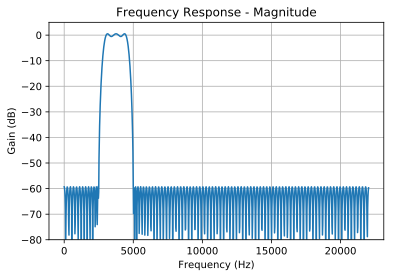

In [11]:
b = fir_d.fir_remez_bpf(2500,3000,4500,5000,.5,60,44100,18)
fir_d.freqz_resp_list([b],[1],'dB',44100)
ylim([-80,5])
grid();

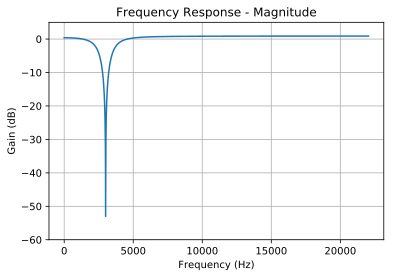

In [21]:
# Design an IIR Notch
b, a = ss.fir_iir_notch(3000,44100,r= 0.9)
fir_d.freqz_resp_list([b],[a],'dB',44100,4096)
ylim([-60,5])
grid();

Create some global variables for the filter coefficients and the filter state array (recall that a filter has memory).

In [13]:
# For the FIR filter 'b' is defined above, but 'a' also needs to be declared
# For the IIR notch filter both 'b' and 'a' are declared above
a = [1]
zi = signal.lfiltic(b,a,[0])
#zi = signal.sosfilt_zi(sos)

In [14]:
# define callback (#2)
def callback2(in_data, frame_count, time_info, status):
    global b, a, zi
    DSP_IO.DSP_callback_tic()
    # convert byte data to ndarray
    in_data_nda = np.fromstring(in_data, dtype=np.int16)
    #***********************************************
    # DSP operations here
    # Here we apply a linear filter to the input
    x = in_data_nda.astype(float32)
    #y = x
    # The filter state/(memory), zi, must be maintained from frame-to-frame 
    y, zi = signal.lfilter(b,a,x,zi=zi) # for FIR or simple IIR
    #y, zi = signal.sosfilt(sos,x,zi=zi) # for IIR use second-order sections    
    #***********************************************
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y) 
    #***********************************************
    # Convert from float back to int16
    y = y.astype(int16)
    DSP_IO.DSP_callback_toc()
    return y.tobytes(), pah.pyaudio.paContinue

In [15]:
DSP_IO = pah.DSP_io_stream(callback2,2,1,Tcapture=0)

In [16]:
DSP_IO.stream(5)

Audio input/output streaming session complete!


# Real-Time Playback
The case of real-time playback sends an `ndarray` through the chosen audio output path with the array data either being truncated or looped depending upon the length of the array relative to `Tsec` supplied to `stream(Tsec)`. To manage the potential looping aspect of the input array, we first make a `loop_audio` object from the input array. An example of this shown below:

In [19]:
# define callback (2)
# Here we configure the callback to play back a wav file                      
def callback3(in_data, frame_count, time_info, status):
    
    DSP_IO.DSP_callback_tic()
    
    # Ignore in_data when generating output only
    #***********************************************
    global x
    # Note wav is scaled to [-1,1] so need to rescale to int16
    y = 32767*x.get_samples(frame_count)
    # Perform real-time DSP here if desired
    #
    #***********************************************
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y)
    #***********************************************
    # Convert from float back to int16
    y = y.astype(int16)
    DSP_IO.DSP_callback_toc()
    return y.tobytes(), pah.pyaudio.paContinue

In [32]:
#fs, x_wav = ss.from_wav('OSR_us_000_0018_8k.wav')
fs, x_wav2 = ss.from_wav('Music_Test.wav')
x_wav = (x_wav2[:,0] + x_wav2[:,1])/2
#x_wav = x_wav[15000:90000]
x = pah.loop_audio(x_wav)
#DSP_IO = pah.DSP_io_stream(callback3,2,1,fs=8000,Tcapture=2)
DSP_IO = pah.DSP_io_stream(callback3,2,1,fs=44100,Tcapture=2)
DSP_IO.stream(20)

Audio input/output streaming session complete!


# Real-Time Audio Capture/Record
Here we use PyAudio to acquire or capture the signal present on the chosen input device, e.g., microphone or a line-in signal from some sensor or music source. The example captures from the built-in microphone found on most PCs. 

In [ ]:
# define callback (2)
# Here we configure the callback to capture a one channel input
def callback4(in_data, frame_count, time_info, status):
    
    DSP_IO.DSP_callback_tic()
    
    # convert byte data to ndarray
    in_data_nda = np.fromstring(in_data, dtype=np.int16)
    #***********************************************
    # DSP operations here
    # Here we apply a linear filter to the input
    x = in_data_nda.astype(float32)
    y = x 
    #***********************************************
    # Save data for later analysis
    # accumulate a new frame of samples
    DSP_IO.DSP_capture_add_samples(y)
    #***********************************************
    # Convert from float back to int16
    y = 0*y.astype(int16)
    DSP_IO.DSP_callback_toc()
    # Convert ndarray back to bytes
    #return (in_data_nda.tobytes(), pyaudio.paContinue)
    return y.tobytes(), pah.pyaudio.paContinue

In [ ]:
DSP_IO = pah.DSP_io_stream(callback4,0,1,fs=22050)
DSP_IO.stream(5)

## Capture Buffer Analysis
As each of the above real-time processing scenarios is run, move down here in the notebook to do some analysis of what happened.
* The `stream_stats()` provides statistics related to the real-time performance
* What is the period between callbacks, ideal not contention theory and measured
* The average time spent in the callback
    * The frame-based processing approach taken by `PyAudio` allows for efficient processing at the expense of latency in getting the first input sample to the output
    * With a large `frame_length` and the corresponding latency, a lot of processing time is available to get DSP work done
* The object `DSP_IO` also contains a capture buffer (an ndarray), `data_capture`
* Post processing this buffer allows further study of what was passed to the output of the DSP IP itself
* In the case of a capture only application, the array `data_capture` is fundamental interest, as this is what you were seeking

In [13]:
DSP_IO.stream_stats()

Ideal Callback period = 23.22 (ms)
Average Callback Period = 23.22 (ms)
Average Callback process time = 0.31 (ms)


Note for a attributes used in the above examples the `frame_length` is alsways 1024 samples and the sampling rate $f_s = 44.1$ ksps. The ideal callback period is this
$$
    T_{cb} = \frac{1024}{44100} = 23.22\ \text{(ms)}
$$

In [30]:
T_cb = 1024/44100 * 1000 # times 1000 to get units of ms
print('Callback/Frame period = %1.4f (ms)' % T_cb)

Callback/Frame period = 23.2200 (ms)


Next consider what the captures `tic` and `toc` data revels about the processing. Calling the method `cb_active_plot()` produces a plot similar to what an electrical engineer would see what using a logic analyzer to show the time spent in an *interrupt service routine* of an *embedded system*. The latency is also evident. You expect to see a minimum latency of two frame lengths (input buffer fill and output buffer fill),e.g.,
$$
    T_\text{latency} >= 2\times \frac{1024}{44100} \times 1000 = 56.44\ \text{(ms)}
$$
The host processor is multitasking, so the latency can be even greater. A true real-time DSP system would give the signal processing high priority and hence much lower latency is expected.

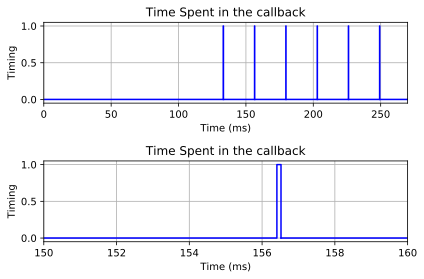

In [32]:
subplot(211)
DSP_IO.cb_active_plot(0,270) # enter start time (ms) and stop time (ms)
subplot(212)
DSP_IO.cb_active_plot(150,160)
tight_layout()

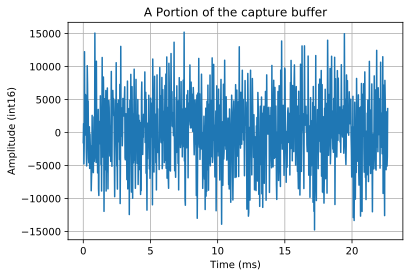

In [35]:
Npts = 1000
Nstart = 1000
plot(arange(len(DSP_IO.data_capture[Nstart:Nstart+Npts]))*1000/44100,
     DSP_IO.data_capture[Nstart:Nstart+Npts])
title(r'A Portion of the capture buffer')
ylabel(r'Amplitude (int16)')
xlabel(r'Time (ms)')
grid();

Finally, the spectrum of the output signal. To apply custon scaling we use a variation of `psd()` found in the `sigsys` module. If we are plotting the spectrum of *white* noise sent through a filter, the output PSD will be of the form $\sigma_w^2|H(e^{j2\pi f/f_s})|^2$, where $\sigma_w^2$ is the variance of the noise driving the filter. You may choose to overlay a plot of

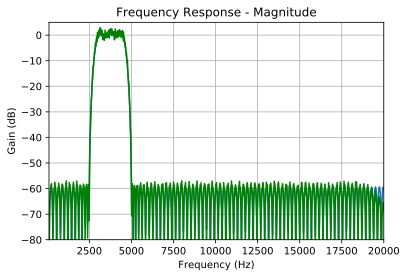

In [17]:
Pxx, F = ss.my_psd(DSP_IO.data_capture,2**13,44100);
fir_d.freqz_resp_list([b],[a],'dB',44100)
plot(F,10*log10(Pxx/max(Pxx))+3,'g') # Normalize by the max PSD
ylim([-80,5])
xlim([100,20e3])
grid();

In [ ]:
specgram(DSP_IO.data_capture,1024,44100);
ylim([0, 5000])

# What to Try Next?
